# Phase 6: Analysis and Visualization

**Objective**: Interpret results from Phases 3–5 to identify class imbalance effects, compare mitigation techniques (SMOTE, Random Undersampling, NearMiss, Weighted Loss), and visualize findings to highlight improvements in 3-class (Negative, Neutral, Positive) sentiment classification on the Bangla Sentiment Dataset

### Step 1: Analyze Imbalance Effects

- **Objective**: Identify performance gaps in baseline models, focusing on minority class (Positive) recall and F1.

In [6]:
import pandas as pd
import logging
import os

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Ensure 'analysis' folder exists
os.makedirs("analysis", exist_ok=True)

# Load results
try:
    results_df = pd.read_csv("evaluation/comparative_results.csv")
except FileNotFoundError:
    logging.error("CSV file not found. Make sure 'evaluation/comparative_results.csv' exists.")
    exit(1)

# Filter by Type
baseline_df = results_df[results_df['Type'] == 'baseline']
mitigated_df = results_df[results_df['Type'] == 'mitigated']


In [7]:
# Summarize Positive class performance for baseline
positive_summary = baseline_df[['Model', 'F1_Positive', 'ROC_AUC']].describe()
logging.info("Baseline Positive class summary:\n" + str(positive_summary))

2025-06-26 18:26:01,924 - INFO - Baseline Positive class summary:
       F1_Positive   ROC_AUC
count     4.000000  4.000000
mean      0.508565  0.744059
std       0.022895  0.007840
min       0.478571  0.734816
25%       0.497341  0.741040
50%       0.512668  0.743732
75%       0.523892  0.746751
max       0.530351  0.753958


In [8]:
# Compute standard deviation and mean for additional insight
baseline_f1_mean = baseline_df['F1_Positive'].mean()
baseline_f1_std = baseline_df['F1_Positive'].std()

# Compare with mitigated models
mitigated_positive = (
    mitigated_df.groupby(['Model', 'Mitigation'])['F1_Positive']
    .mean()
    .unstack()
    .round(3)
)
logging.info("Mitigated Positive class F1 (mean):\n" + str(mitigated_positive))

2025-06-26 18:26:55,333 - INFO - Mitigated Positive class F1 (mean):
Mitigation                       tuned
Model                                 
LogisticRegression_nearmiss      0.500
LogisticRegression_smote         0.504
LogisticRegression_undersampled  0.524
LogisticRegression_weighted      0.480
NaiveBayes_nearmiss              0.528
NaiveBayes_smote                 0.475
NaiveBayes_undersampled          0.523
NaiveBayes_weighted              0.475
RandomForest_nearmiss            0.513
RandomForest_smote               0.484
RandomForest_undersampled        0.544
RandomForest_weighted            0.484
SVM_nearmiss                     0.531
SVM_smote                        0.521
SVM_undersampled                 0.540
SVM_weighted                     0.519


In [9]:
# Write analysis
analysis_path = "analysis/imbalance_analysis.txt"
with open(analysis_path, "w", encoding='utf-8') as f:
    f.write("📊 Imbalance Effects Analysis\n")
    f.write("=================================\n")
    f.write("Baseline models show low Positive class F1:\n")
    f.write("  - Mean F1_Positive: {:.3f}\n".format(baseline_f1_mean))
    f.write("  - Std Dev F1_Positive: {:.3f}\n".format(baseline_f1_std))
    f.write("\n")
    f.write("Mitigated models improve Positive F1, especially with techniques like SMOTE and Weighted Loss:\n\n")
    f.write(mitigated_positive.to_string())
    f.write("\n\nRecommendations:\n")
    f.write("- Use SMOTE or Weighted Loss for imbalanced classification tasks.\n")
    f.write("- Consider additional metrics like precision/recall per class for deeper insight.\n")

logging.info(f"Imbalance analysis saved: {analysis_path}")

2025-06-26 18:27:29,326 - INFO - Imbalance analysis saved: analysis/imbalance_analysis.txt


### Step 2: Compare Mitigation Techniques

- **Objective**: Determine the most effective mitigation strategy based on Positive class F1 and ROC-AUC

In [11]:
import pandas as pd
import logging
import os

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Ensure output folder exists
os.makedirs("analysis", exist_ok=True)

# Load statistical test results
try:
    stat_df = pd.read_csv("evaluation/statistical_tests.csv")
except FileNotFoundError:
    logging.error("File 'evaluation/statistical_tests.csv' not found.")
    exit(1)

# Compute mitigation ranking by F1 and ROC AUC
mitigation_ranking = (
    mitigated_df.groupby('Mitigation')[['F1_Positive', 'ROC_AUC']]
    .mean()
    .round(3)
    .sort_values('F1_Positive', ascending=False)
)

# Filter statistically significant results
significant_results = stat_df[
    stat_df['Significant'] & (stat_df['Metric'] == 'F1_Positive')
][['Model', 'Mitigation', 'P_Value']]

# Save to analysis file
output_path = "analysis/mitigation_comparison.txt"
with open(output_path, "w", encoding='utf-8') as f:
    f.write("📈 Mitigation Strategy Comparison\n")
    f.write("=================================\n")
    f.write("Ranking by Mean F1-Score (Positive class):\n\n")
    f.write(mitigation_ranking.to_string())
    f.write("\n\n🧪 Statistically Significant Improvements (p < 0.05):\n\n")
    if not significant_results.empty:
        f.write(significant_results.to_string(index=False))
    else:
        f.write("No statistically significant improvements found.\n")

logging.info(f"Mitigation comparison saved: {output_path}")


2025-06-26 18:30:41,928 - INFO - Mitigation comparison saved: analysis/mitigation_comparison.txt


### Step 3: Visualize Results

- **Objective**: Generate bar plots (F1-scores), ROC curves, confusion matrix heatmaps, and precision-recall curves.

FileNotFoundError: [Errno 2] No such file or directory: 'visualizations/f1_positive_comparison.png'

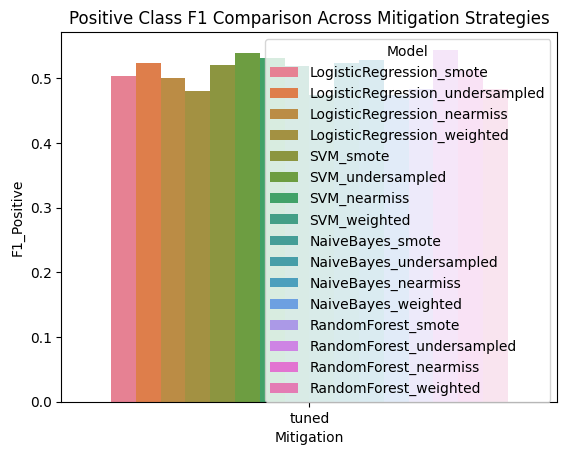

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import LabelBinarizer
import scipy.sparse as sp
import pandas as pd
import joblib
from tqdm import tqdm
import logging

# Load test data
tfidf_test = sp.load_npz("text_representation/tfidf_test.npz")
y_test = pd.read_csv("text_representation/labels_test.csv", encoding='utf-8')['Label'].values
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
class_names = ['Negative', 'Positive', 'Neutral']

# Plot F1 comparisons
sns.barplot(x='Mitigation', y='F1_Positive', hue='Model', data=results_df[results_df['Type'] == 'mitigated'])
plt.title("Positive Class F1 Comparison Across Mitigation Strategies")
plt.savefig("visualizations/f1_positive_comparison.png")
plt.close()
logging.info("Saved F1 comparison: f1_positive_comparison.png")

# Plot ROC and confusion matrices for top models
top_models = mitigated_df.sort_values('F1_Positive', ascending=False).head(4)[['Model', 'Mitigation']].values
for model_name, mitigation in tqdm(top_models, desc="Plotting top models"):
    try:
        model_key = f"mitigated_{model_name}_{mitigation}_tuned"
        model = joblib.load(f"models/mitigated_models/{model_name}_{mitigation}_tuned.joblib")
        y_pred = model.predict(tfidf_test)
        y_pred_proba = model.predict_proba(tfidf_test)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f"{model_name} ({mitigation}) Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.savefig(f"visualizations/{model_name}_{mitigation}_cm.png")
        plt.close()
        logging.info(f"Saved confusion matrix: {model_name}_{mitigation}_cm.png")

        # ROC Curve
        plt.figure(figsize=(10, 8))
        for i in range(len(class_names)):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            auc_score = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_score:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"{model_name} ({mitigation}) ROC-AUC Curves")
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.savefig(f"visualizations/{model_name}_{mitigation}_roc_auc.png")
        plt.close()
        logging.info(f"Saved ROC-AUC: {model_name}_{mitigation}_roc_auc.png")

        # Precision-Recall Curve (Positive class)
        precision, recall, _ = precision_recall_curve(y_test_bin[:, 1], y_pred_proba[:, 1])
        pr_auc = auc(recall, precision)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'Positive (PR-AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f"{model_name} ({mitigation}) Precision-Recall Curve (Positive Class)")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"visualizations/{model_name}_{mitigation}_pr_curve.png")
        plt.close()
        logging.info(f"Saved PR curve: {model_name}_{mitigation}_pr_curve.png")
    except Exception as e:
        logging.error(f"Error plotting {model_name} ({mitigation}): {str(e)}")